<a href="https://colab.research.google.com/github/saankhya1997/Pet-Image-Classifier/blob/master/Pet_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pet Image Classifier Project using Inception Network.

This project deals with the classification of 37 different kind of pets that are different breeds of cats and dogs. In this project the new Tensorflow 2.0 version has been used. We have dowloaded and installed the dataset using the Tensorflow datasets. For image classification using convolutional neural networks, we often require a large networks to achieve better accuracy. However, training such network is computationally costly and requires high speed hardwares, GPU. Hence we make use of pre trained model. There are various highly accurate pre trained model avalilable such as AlexNet, ResNets, Inception Nets and MobileNet. In this project, the inception network is used.
We have downwloaded the network using Tensorflow hub. 


First, let's install Tensorflow Hub and Tensorflow datasets.

In [0]:
!pip install tf-nightly-gpu
!pip install "tensorflow_hub==0.4.0"
!pip install -U tensorflow_datasets

     |████████████████████████████████| 375.4MB 45kB/s 
     |████████████████████████████████| 491kB 48.1MB/s 
     |████████████████████████████████| 3.1MB 45.3MB/s 
     |████████████████████████████████| 61kB 28.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/89/67/41/63cbf0f6ac0a6156588b9587be4db5565f8c6d8ccef98202fc
Successfully built wrapt
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
  Found existing installation: wrapt 1.10.11
    Uninstalling wrapt-1.10.11:
      Successfully uninstalled wrapt-1.10.11


     |████████████████████████████████| 686kB 3.4MB/s 


We will import the necessary modules.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
tf.enable_eager_execution()
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import numpy as np

Let's download the inception network model using the given URL. The model had been trained using 299 * 299 * 3 image shapes. Hence, we set the image size to 299. We design a model using tensorflow and keras. 

In [0]:
classifier_URL = "https://tfhub.dev/google/tf2-preview/inception_v3/classification/3"
image_size = 299
model = tf.keras.Sequential([hub.KerasLayer(classifier_URL, input_shape=(image_size, image_size, 3))])

Now, we are going to download the dataset. First, we are splitting our labeled dataset into two parts - 80% for training and 20% for testing our network.

In [0]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 20))
splits, info = tfds.load('oxford_iiit_pet', with_info=True, as_supervised=True, split = splits)

train_examples, test_examples = splits

num_examples = info.splits['train'].num_examples + info.splits['test'].num_examples
num_classes = info.features['label'].num_classes
info.description

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/1.1.0. Subsequent calls will reuse this data.


'The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200\nimages for each class. The images have large variations in scale, pose and\nlighting. All images have an associated ground truth annotation of breed.\n'

In [0]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=1.1.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.
',
    urls=['http://www.robots.ox.ac.uk/~vgg/data/pets/'],
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string, encoder=None),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37)
    },
    total_num_examples=7349,
    splits={
        'test': <tfds.core.SplitInfo num_examples=3669>,
        'train': <tfds.core.SplitInfo num_examples=3680>
    },
    supervised_keys=('image', 'label'),
    citation='"""
        @InProceedings{parkhi12a,
          author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Jawahar, C.~V.",
          title        = "Cats and Dog

There are a total of 7349 examples and 37 classes.

In [0]:
print(num_examples)
print(num_classes)


7349
37


The dataset has images of varied sizes. We have to resize each image to the desired shape which is 299 * 299 * 3. Here's a function that resizes the images and normalizes its pixel values. 

In [0]:
def resize(image, label):
  image = tf.image.resize(image, (image_size, image_size))/255.
  return image, label

We going to use Adam optimization algorithm using batch gradient descent. We have diving the datasets into a batch size of 32. All the trainable parameters are updated after a batch of given size has trained the parameters.
Also, we shuffle the examples in the training set for each epoch.

In [0]:
batch_size = 32
train_batches = train_examples.shuffle(num_examples).map(resize).batch(batch_size).prefetch(1)
test_batches = test_examples.map(resize).batch(batch_size).prefetch(1)

We now downwload the inception model feature vector which is pre trained from the Tensorflow Hub. We extract the features and keep all the parameters untrainable.

In [0]:
feature_vector_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/3"
feature_extractor = hub.KerasLayer(feature_vector_url, input_shape=(image_size, image_size, 3))
feature_extractor.trainable = False

We now design the model by adding a fully connected layer with 1000 units and then we applied a drop out of 0.4 to reduce overfitting. Then we connected a softmax layer consisting of 37 units.

In [0]:
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(1000, activation = 'relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation = 'softmax')
])

This is the model summary.

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              2049000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 37)                37037     
Total params: 23,888,821
Trainable params: 2,086,037
Non-trainable params: 21,802,784
_________________________________________________________________


We will use the adam optimization algorithm to train the last two layers in the network.

In [0]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

We are keeping the number of epochs equal to 25 which means the algorithm will run through the entire training set 25 times.

In [0]:
epochs = 25
history = model.fit(train_batches, epochs = epochs, validation_data = test_batches)

Epoch 1/25
185/185 [==============================] - 49s 262ms/step - loss: 1.2239 - acc: 0.7126 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/25
185/185 [==============================] - 42s 229ms/step - loss: 0.6765 - acc: 0.8565 - val_loss: 0.5882 - val_acc: 0.8847
Epoch 3/25
185/185 [==============================] - 41s 224ms/step - loss: 0.5920 - acc: 0.8763 - val_loss: 0.5649 - val_acc: 0.8931
Epoch 4/25
185/185 [==============================] - 43s 233ms/step - loss: 0.5301 - acc: 0.8993 - val_loss: 0.5820 - val_acc: 0.8889
Epoch 5/25
185/185 [==============================] - 42s 227ms/step - loss: 0.4705 - acc: 0.9145 - val_loss: 0.5718 - val_acc: 0.8917
Epoch 6/25
185/185 [==============================] - 43s 230ms/step - loss: 0.4419 - acc: 0.9247 - val_loss: 0.5979 - val_acc: 0.8861
Epoch 7/25
185/185 [==============================] - 42s 229ms/step - loss: 0.4358 - acc: 0.9286 - val_loss: 0.5675 - val_acc: 0.8986
Epoch 8/25
185/185 [===========================

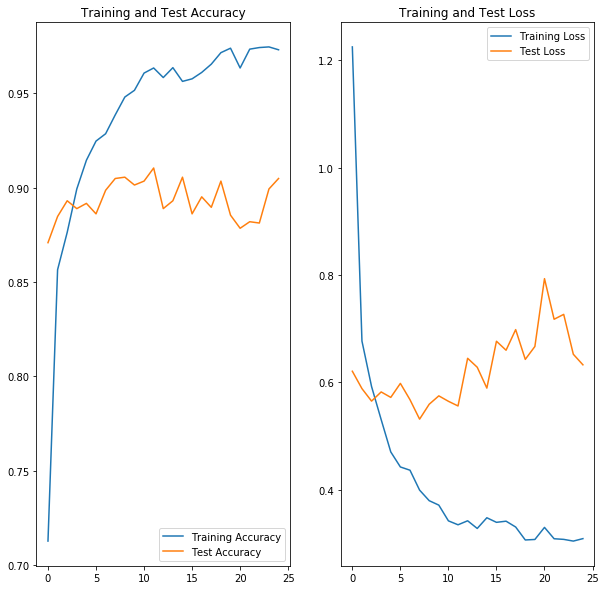

In [0]:
accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

loss = history.history['loss']
test_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, test_accuracy, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')
plt.show()

Let's predict some results.

In [0]:
image_batch, label_batch = next(iter(test_batches))
class_names = np.array(info.features['label'].names)
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
print(class_names)
print(predicted_class_names)

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31' '32' '33' '34' '35' '36']
['4' '34' '15' '30' '7' '23' '14' '36' '11' '36' '20' '15' '12' '10' '22'
 '31' '19' '27' '2' '1' '33' '5' '0' '3' '4' '11' '0' '17' '11' '29' '27'
 '34']


In [0]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [ 3  2 15 12  7 23 14 36 11 36 20 15 12 10 22 31 19 27  2  1 33  5  0  3
  4  5  0 17 11 29  9  2]
Predicted labels:  [ 4 34 15 30  7 23 14 36 11 36 20 15 12 10 22 31 19 27  2  1 33  5  0  3
  4 11  0 17 11 29 27 34]


In [0]:
label_batch == predicted_ids

array([False, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True, False, False])

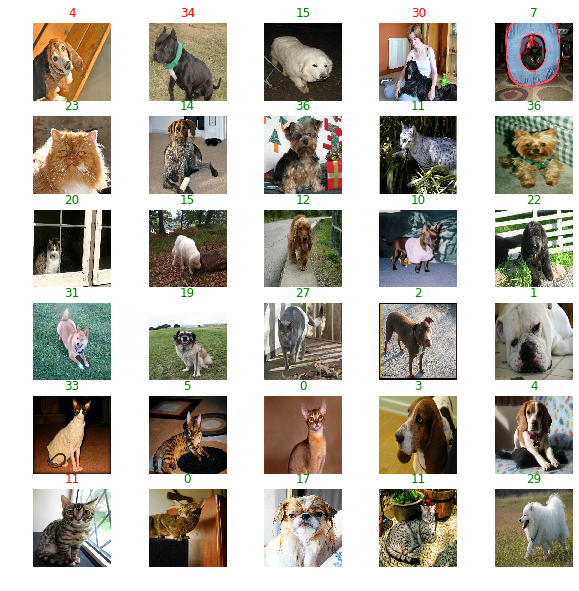

In [0]:
plt.figure(figsize=(10,10))
for i in range(30):
  plt.subplot(6,5,i+1)
  plt.imshow(image_batch[i])
  if label_batch[i] == predicted_ids[i]:
    color = "green"
  else:
    color = "red"
  plt.title(predicted_class_names[i].title(), color=color)
  plt.axis('off')

To conclude, we have used the Tensorflow 2.0 framework to classify different breeds of pets using the Inception Networks. An accuracy of 97 % was obtained on the training set and 90 % on the test set. For achieving better accuracies, ResNets are used. However, it's not available for Tensorflow 2.0. So, we used Inception Network.